# Background

Customer churn is defined as the number of customers who have stopped doing business with a company during a given time period. Churn poses a problem for a business as it lowers revenues and profits. Moreover, attracting new customers [costs 5 to 25 times more expensive](https://hbr.org/2014/10/the-value-of-keeping-the-right-customers) than retaining existing ones. [According to Bain & Co.](https://media.bain.com/Images/BB_Prescription_cutting_costs.pdf), increasing customer retention by 5% will increase profits to more than 25%.

Accurately predicting churn and identifying the relevant factors can help a company develop effective customer retention strategies which, in turn, reduce churn.

# Data

A newer version of telco customer churn data is used in this notebook, obtained from a data module in [IBM Accelerator Catalog](https://community.ibm.com/accelerators/?context=analytics&type=Data&industry=Telecommunications). The original module contains five data tables, but only three will be considered for analysis: `Demographics`, `Services`, and `Status`. A detailed description of columns in each table is available on [IBM Business Analytics Community](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113).

In [1]:
# Data manipulation, visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
!pip install openpyxl

# Preprocessing, modeling, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [2]:
path = '/kaggle/input/telco-customer-churn-1113/'  # Read in datasets
stat = pd.read_excel(path+'Telco_customer_churn_status.xlsx')
demo = pd.read_excel(path+'Telco_customer_churn_demographics.xlsx')
serv = pd.read_excel(path+'Telco_customer_churn_services.xlsx')

key = ['Customer ID']
df = stat.merge(  # Merge into a single dataframe
    demo, left_on=key, right_on=key).merge(
    serv, left_on=key, right_on=key)
df.head()

,Customer ID,Count_x,Quarter_x,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,...,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
0,8779-QRDMV,1,Q3,3,Churned,Yes,1,91,5433,Competitor,...,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65
1,7495-OOKFY,1,Q3,3,Churned,Yes,1,69,5302,Competitor,...,Yes,Month-to-Month,Yes,Credit Card,80.65,633.30,0.00,0,390.80,1024.10
2,1658-BYGOY,1,Q3,2,Churned,Yes,1,81,3179,Competitor,...,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88
3,4598-XLKNJ,1,Q3,2,Churned,Yes,1,88,5337,Dissatisfaction,...,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50,2514.50,13.43,0,494.00,2995.07
4,4846-WHAFZ,1,Q3,2,Churned,Yes,1,67,2793,Price,...,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36


After the tables are loaded, they are merged into a single data frame. Each table contains one identical column, `Customer ID`, on which the merging is performed. A total of 48 columns are output, but some are dropped because they contain redundant information, are already directly related to churn, or are highly related with other columns (which can result in multicollinearity).

In [3]:
to_drop = [  # Drop columns not used in the analyses
    'Customer ID',
    'Count_x',
    'Quarter_x',
    'Customer Status',
    'Churn Value',
    'Churn Score',
    'Churn Category',
    'Churn Reason',
    'Count_y',
    'Age',
    'Number of Dependents',
    'Quarter_y',
    'Referred a Friend',
    'Number of Referrals',
    'Phone Service',
    'Internet Service',
    'Streaming Music',
    'Total Charges',
    'Total Refunds',
    'Total Extra Data Charges',
    'Total Long Distance Charges',
    'Total Revenue']
df.drop(to_drop, axis=1, inplace=True)

# Data Exploration

There are 7043 observations in the data frame, each representing a unique customer. A majority of the columns contain categorical data of the nominal type, e.g., `Yes` or `No`. Six columns are of the numerical type, namely: `Satisfaction Score`, `CLTV`, `Tenure in Months`, `Avg Monthly Long Distance Charges`, `Avg Monthly GB Download`, and `Monthly Charge`. The column `Count` is only kept for the purpose of aggregating data and creating visualizations; it will be removed later. Upon checking, the data frame contains neither missing values nor duplicated rows.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Satisfaction Score                 7043 non-null   int64  
 1   Churn Label                        7043 non-null   object 
 2   CLTV                               7043 non-null   int64  
 3   Gender                             7043 non-null   object 
 4   Under 30                           7043 non-null   object 
 5   Senior Citizen                     7043 non-null   object 
 6   Married                            7043 non-null   object 
 7   Dependents                         7043 non-null   object 
 8   Count                              7043 non-null   int64  
 9   Tenure in Months                   7043 non-null   int64  
 10  Offer                              7043 non-null   object 
 11  Avg Monthly Long Distance Charges  7043 non-null   float

In [5]:
df.isna().sum()  # Check for missing values

Satisfaction Score                   0
Churn Label                          0
CLTV                                 0
Gender                               0
Under 30                             0
Senior Citizen                       0
Married                              0
Dependents                           0
Count                                0
Tenure in Months                     0
Offer                                0
Avg Monthly Long Distance Charges    0
Multiple Lines                       0
Internet Type                        0
Avg Monthly GB Download              0
Online Security                      0
Online Backup                        0
Device Protection Plan               0
Premium Tech Support                 0
Streaming TV                         0
Streaming Movies                     0
Unlimited Data                       0
Contract                             0
Paperless Billing                    0
Payment Method                       0
Monthly Charge           

In [6]:
df.duplicated().sum()  # Check for duplicated data

0

In [7]:
df.describe()  # Obtain statistical summary: numeric data

,Satisfaction Score,CLTV,Count,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge
count,7043.000000,7043.000000,7043.0,7043.000000,7043.000000,7043.000000,7043.000000
mean,3.244924,4400.295755,1.0,32.386767,22.958954,20.515405,64.761692
std,1.201657,1183.057152,0.0,24.542061,15.448113,20.418940,30.090047
min,1.000000,2003.000000,1.0,1.000000,0.000000,0.000000,18.250000
25%,3.000000,3469.000000,1.0,9.000000,9.210000,3.000000,35.500000
50%,3.000000,4527.000000,1.0,29.000000,22.890000,17.000000,70.350000
75%,4.000000,5380.500000,1.0,55.000000,36.395000,27.000000,89.850000
max,5.000000,6500.000000,1.0,72.000000,49.990000,85.000000,118.750000


In [8]:
df.describe(include='O')  # Obtain statistical summary: categorical data

,Churn Label,Gender,Under 30,Senior Citizen,Married,Dependents,Offer,Multiple Lines,Internet Type,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Unlimited Data,Contract,Paperless Billing,Payment Method
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,2,2,6,2,4,2,2,2,2,2,2,2,3,2,3
top,No,Male,No,No,No,No,None,No,Fiber Optic,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal
freq,5174,3555,5642,5901,3641,5416,3877,4072,3035,5024,4614,4621,4999,4336,4311,4745,3610,4171,3909


In [9]:
cpal = {'No':'#76528BFF', 'Yes':'#DF6589FF'}

def visualize_labels(img_title, df, col):
    fig, ax = plt.subplots(figsize=(6,5))
    sns.countplot(data=df, x=col, palette=cpal)
    for bar in ax.patches:
        height = bar.get_height()
        width = bar.get_width()
        col_total = df[col].count()
        pct = 100*height/(col_total)
        ax.text(bar.get_x() + width/2,
                bar.get_y() + height/2,
                f'{int(height)}',
                ha='center', va='center',
                color='white', weight='bold')
        ax.text(bar.get_x() + width/2,
                bar.get_y() + height/2 - 300,
                f'({pct:.1f}%)',
                ha='center', va='center',
                color='white', weight='bold')
    for pos in ['right', 'top', 'left']:
        ax.spines[pos].set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel(None)
    ax.set_title(f'{col}', loc='left', weight='bold')
    fig.savefig(f'{img_title}.png', dpi=300, bbox_inches='tight')
    
def stack_bar(img_title, df, cols):
    fig, axes = plt.subplots(1, 3, figsize=(16,5), sharey=True)
    for i, col in enumerate(cols):
        # Calculate totals and percentages
        total = df.groupby(col)['Count'].sum().reset_index()
        churn = df[df['Churn Label']=='Yes'].groupby(col)['Count'].sum().reset_index()
        churn['Count'] = [100*i/j for i,j in zip(churn['Count'], total['Count'])]
        total['Count'] = [100*i/j for i,j in zip(total['Count'], total['Count'])]
        bar1 = sns.barplot(  # top bars (group of 'Churn = No')
            x=col, y='Count', data=total, color=cpal['No'], ax=axes[i])
        bar2 = sns.barplot(  # bottom bars (group of 'Churn = Yes')
            x=col, y='Count', data=churn, color=cpal['Yes'], ax=axes[i])
        top_bar = mpatches.Patch(color=cpal['No'], label='Not Churn')
        bot_bar = mpatches.Patch(color=cpal['Yes'], label='Churn')  
        axes[i].legend(loc='lower center', ncol=2,
                       bbox_to_anchor=(0.5, -0.21),
                       handles=[top_bar, bot_bar])
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].set_xlabel(None)
        axes[i].set_ylabel('Percentage')
        axes[i].set_title(f'{col}', loc='left', weight='bold')  
        if i != 0:
            axes[i].legend().set_visible(False)
            axes[i].set_ylabel(None)
        else:
            pass
        for bar in axes[i].patches:
            if bar.get_height() != 100:
                axes[i].text(bar.get_x() + bar.get_width()/2,
                             bar.get_y() + bar.get_height()/2,
                             f'{int(bar.get_height())}%',
                             ha='center', va='center',
                             color='white', weight='bold')
    fig.savefig(f'{img_title}.png', dpi=300, bbox_inches='tight')

def unstack_bar(img_title, df, col):
    fig, ax = plt.subplots(figsize=(6,5))
    ax = sns.countplot(data=df, x=col, hue='Churn Label', palette=cpal)
    ax.legend(loc='lower center', ncol=2,
              bbox_to_anchor=(0.5, -0.21),
              labels=['Churn = Yes', 'Churn = No'])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(None)
    ax.set_ylabel('Count')
    ax.set_title(f'{col}', loc='left', weight='bold')
    fig.savefig(f'{img_title}.png', dpi=300, bbox_inches='tight')

def make_boxplot(img_title, df, cols):
    fig, axes = plt.subplots(1, 4, figsize=(18,5))
    for i, col in enumerate(cols):
        ax = sns.boxplot(data=df, x='Churn Label', y=col, palette=cpal, ax=axes[i])
        ax.set_xlabel('Churn')
        ax.set_ylabel(None)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_title(f'{col}', loc='left', weight='bold')
    fig.savefig(f'{img_title}.png', dpi=300, bbox_inches='tight')

def make_histogram(img_title, df, col):
    fig, axes = plt.subplots(figsize=(6,5))
    ax = sns.histplot(x=col, data=df, hue='Churn Label', palette=cpal,
                      bins=6, multiple='stack')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(None)
    ax.set_ylabel('Count')
    ax.set_title(f'{col}', loc='left', weight='bold')
    fig.savefig(f'{img_title}.png', dpi=300, bbox_inches='tight')

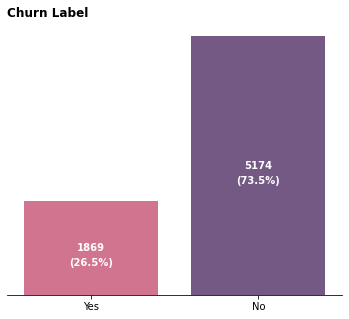

In [10]:
visualize_labels('img-01', df, 'Churn Label')

Our target in this prediction is whether or not a customer will churn, represented by the column `Churn Label`. Looking at the proportion of class labels in said column, however, we see an imbalance. There is an unequal distribution between `Churn Label = Yes` and `Churn Label = No`. A majority of the churn data are labeled `No` while this case places more importance on predicting the `Yes`.

According to Jason Brownlee on [Machine Learning Mastery](https://machinelearningmastery.com/what-is-imbalanced-classification/):
> Imbalanced classifications pose a challenge for predictive modeling as most of the machine learning algorithms used for classification were designed around the assumption of an equal number of examples for each class. This results in models that have poor predictive performance, specifically for the minority class. This is a problem because typically, the minority class is more important and therefore the problem is more sensitive to classification errors for the minority class than the majority class.

In this notebook, the approach used to address class imbalance is to resample the training dataset. [Random oversampling](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/) method is chosen, in which examples in the minority class are randomly duplicated.

In [11]:
categorical_cols = [  # List columns of categorical data type
    'Gender',
    'Under 30',
    'Senior Citizen',
    'Married',
    'Dependents',
    'Offer',
    'Multiple Lines',
    'Internet Type',
    'Online Security',
    'Online Backup',
    'Device Protection Plan',
    'Premium Tech Support',
    'Streaming TV',
    'Streaming Movies',
    'Unlimited Data',
    'Contract',
    'Paperless Billing',
    'Payment Method']
print('PROPORTION OF CATEGORIES ACROSS VARIABLES')
for col in categorical_cols:
    freq = df[col].value_counts(normalize=True).reset_index()
    freq.columns = [f'{col}', 'Proportion']
    print('-'*40+'\n', freq)

PROPORTION OF CATEGORIES ACROSS VARIABLES
----------------------------------------
    Gender  Proportion
0    Male    0.504756
1  Female    0.495244
----------------------------------------
   Under 30  Proportion
0       No    0.801079
1      Yes    0.198921
----------------------------------------
   Senior Citizen  Proportion
0             No    0.837853
1            Yes    0.162147
----------------------------------------
   Married  Proportion
0      No    0.516967
1     Yes    0.483033
----------------------------------------
   Dependents  Proportion
0         No     0.76899
1        Yes     0.23101
----------------------------------------
      Offer  Proportion
0     None    0.550476
1  Offer B    0.116996
2  Offer E    0.114298
3  Offer D    0.085475
4  Offer A    0.073832
5  Offer C    0.058924
----------------------------------------
   Multiple Lines  Proportion
0             No    0.578163
1            Yes    0.421837
----------------------------------------
   Internet 

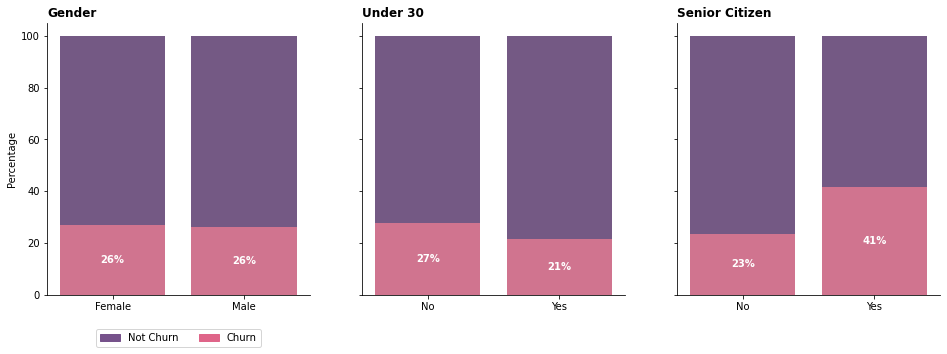

In [12]:
stack_bar('img-02', df, ['Gender', 'Under 30', 'Senior Citizen'])

- There is an almost equal proportion of female (49.5%) and male (50.5%) customers. Both genders have similar churn rate at 26%, signifying that gender has little to no effect on leaving the telco service.
- A large portion of customers (80%) are represented by those under the age of 30. These young customers have churn rate that is 6% lower than customers over 30.
- Senior citizens represent only 16% of total customers but have a relatively high churn rate at 41%, which is almost twice as high as non-senior citizens.

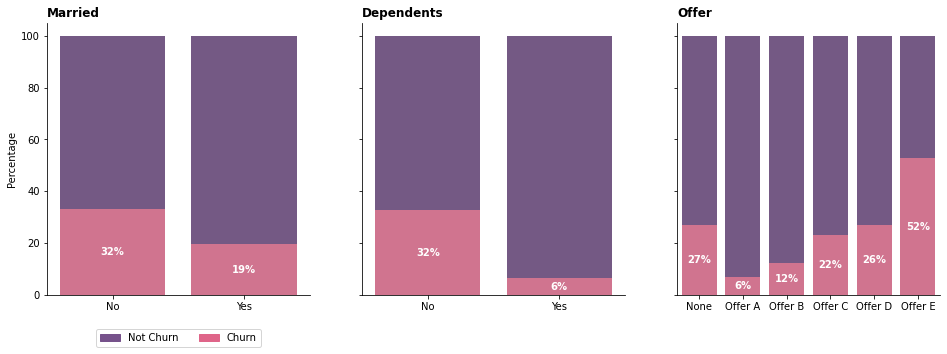

In [13]:
stack_bar('img-03', df, ['Married', 'Dependents', 'Offer'])

- About 52% customers are not married. These customers have 13% higher churn rate than married ones.
- Having dependents (e.g., children) reduce the likelihood of churn. There is only 6% churn among customers that have dependents, about 5 times lower than customers that do not.
- More than 50% of customers who subscribed to *Offer E* have churned in the past quarter, almost twice as high as customers who do not subscribe to any offer.

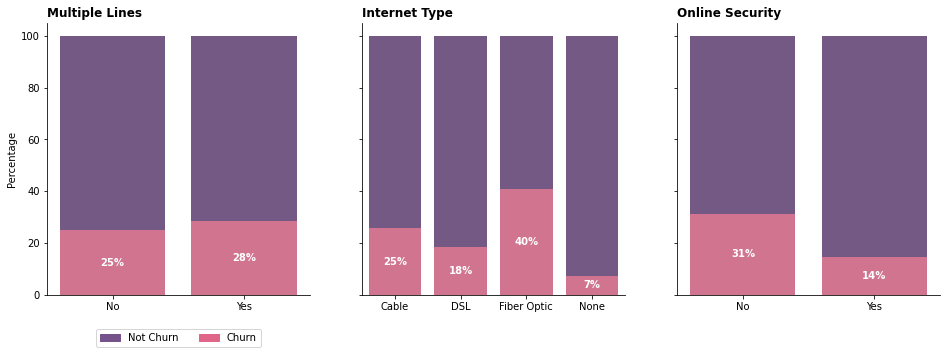

In [14]:
stack_bar('img-04', df, ['Multiple Lines', 'Internet Type', 'Online Security'])

- Customers with multiple phone lines have a slightly higher churn rate than customers without ones; about 3% difference.
- Fiber optic is the most preferred of the three internet service types available, 43% customers have it installed. However, the highest churn (40% rate) is also observed on customers having fiber optic.
- Of customers who subscribe to the online security service (29% of all customers), 14% have churned. Their churn rate is twice as low as customers who do not subscribe.

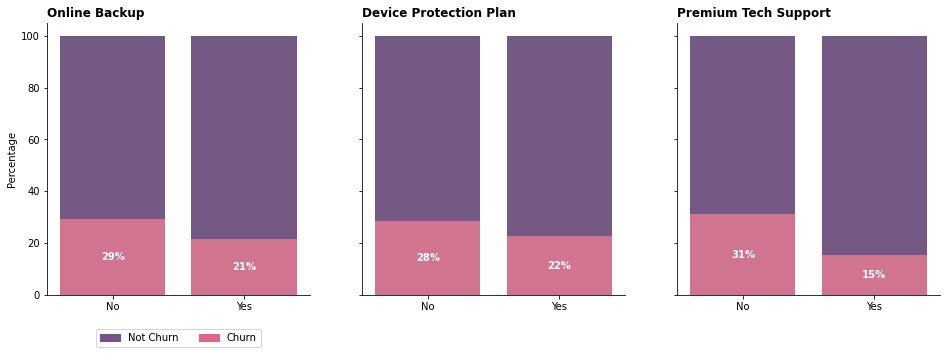

In [15]:
stack_bar('img-05', df, ['Online Backup', 'Device Protection Plan', 'Premium Tech Support'])

- Customers with either online backup or device protection subscription have 6-7% lower churn rate than customers with none of these services.
- About 31% of customers who do not subscribe to premium tech support have churned, the rate is twice as high as customers with support.

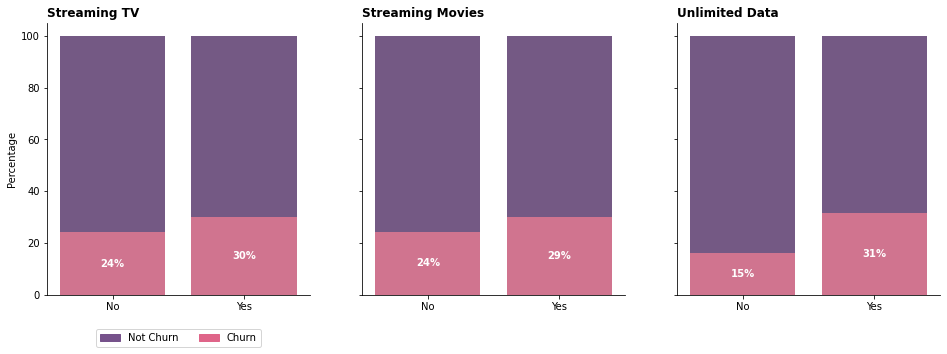

In [16]:
stack_bar('img-06', df, ['Streaming TV', 'Streaming Movies', 'Unlimited Data'])

- Thirty-nine percent of customers have streaming services, either TV or Movies. They have a 5-6% higher churn rate when compared to customers who do not subscribe to any streaming services.
- Thirty-one percent of customers who have unlimited data included in their subscription plan have churned, twice the number of churn in customers with limited data plan.

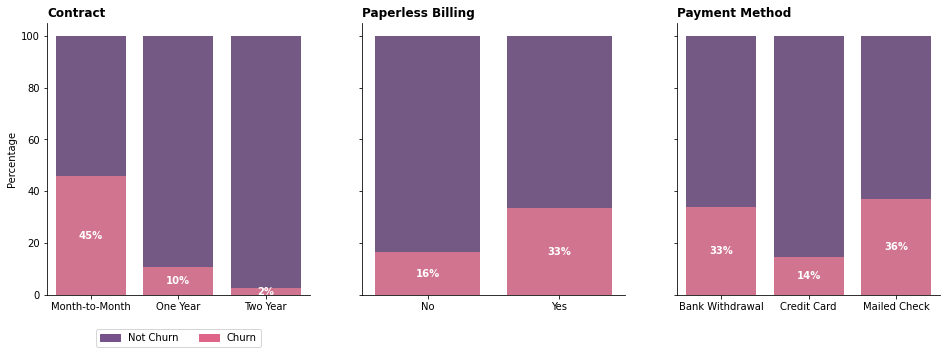

In [17]:
stack_bar('img-07', df, ['Contract', 'Paperless Billing', 'Payment Method'])

- Half of the telco customers (51%) opt for the Month-to-Month subscription plan and they are the most likely to churn when compared to others who opt for a One-Year or Two-Year plan. Customers with longer subscription plans have more than 30% lower churn rate.
- The paperless billing option, preferred by 60% of customers, relates to twice as high churn rate as the other billing option.
- Customers who pay their services with mailed checks, which is the least popular option (only 5% of all customers), have higher churn rate than customers who chose other methods. The most preferred payment method is bank withdrawal (55% customers).

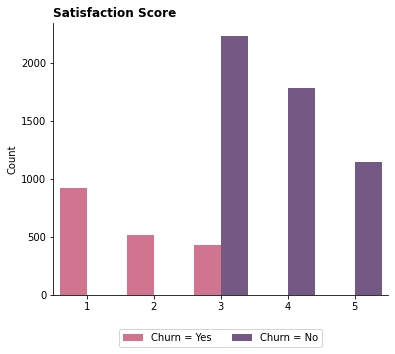

In [18]:
unstack_bar('img-08', df, 'Satisfaction Score')

The chart above shows churn distribution by customer's satisfaction, from a score of 1 (Very Unsatisfied) to 5 (Very Satisfied). We see that customers who give a score of 1 and 2 have all churned. *Unhappy customers stop having business with you*.

In [19]:
numerical_cols = [  # List columns of numerical data type
    'CLTV',
    'Tenure in Months',
    'Avg Monthly Long Distance Charges',
    'Avg Monthly GB Download',
    'Monthly Charge']

med_churn_y = []
med_churn_n = []
for col in numerical_cols:
    med_churn_y.append(df[df['Churn Label']=='Yes'][col].median())
    med_churn_n.append(df[df['Churn Label']=='No'][col].median())

medians = pd.DataFrame(
    index=numerical_cols,
    data={
        'Median_Churn_Yes': med_churn_y,
        'Median_Churn_No': med_churn_n
    })
medians

,Median_Churn_Yes,Median_Churn_No
CLTV,4238.00,4620.000
Tenure in Months,10.00,38.000
Avg Monthly Long Distance Charges,22.88,22.890
Avg Monthly GB Download,19.00,16.000
Monthly Charge,79.65,64.425


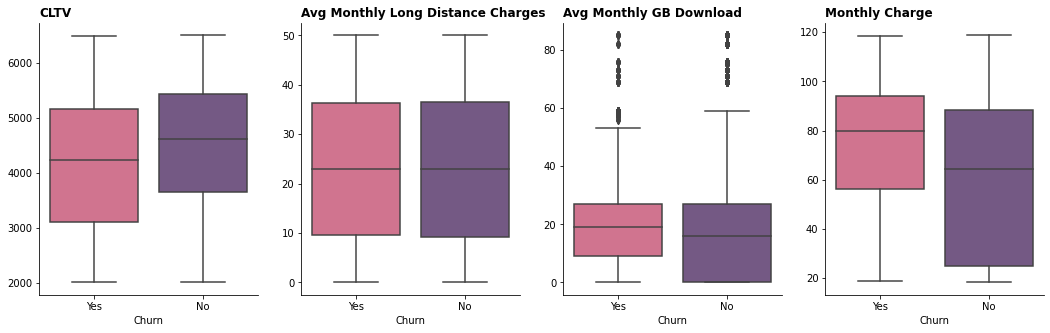

In [20]:
make_boxplot('img-09', df, ['CLTV', 'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Monthly Charge'])

- Customers with low CLTV (customer lifetime value) are more likely to churn than ones with high CLTV.
- Looking at the distribution of data, long distance charges have negligible effect on churn.
- Customers who have churned have a slightly higher average of monthly download and are paying higher monthly charges.

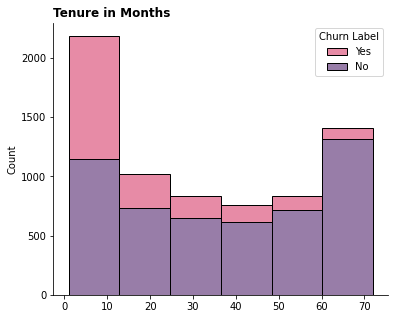

In [21]:
make_histogram('img-10', df, 'Tenure in Months')

We see that new customers (i.e., tenure under 12 months) have the highest cases of churn. On the other hand, it is observed that longer tenures translate into lower proportions of churn, especially in the case of very loyal customers (i.e., tenure over 60 months)

# Preprocessing

In [22]:
df.head()

,Satisfaction Score,Churn Label,CLTV,Gender,Under 30,Senior Citizen,Married,Dependents,Count,Tenure in Months,...,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge
0,3,Yes,5433,Male,No,Yes,No,No,1,1,...,No,Yes,No,No,Yes,No,Month-to-Month,Yes,Bank Withdrawal,39.65
1,3,Yes,5302,Female,No,Yes,Yes,Yes,1,8,...,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Credit Card,80.65
2,2,Yes,3179,Male,No,Yes,No,Yes,1,18,...,No,No,No,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45
3,2,Yes,5337,Female,No,Yes,Yes,Yes,1,25,...,Yes,Yes,No,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50
4,2,Yes,2793,Female,No,Yes,Yes,Yes,1,37,...,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50


A majority of columns in the data frame contains categorical data. However, many machine learning models require numeric inputs. [Encoding and One-Hot Encoding](https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/) are implemented to convert these categorical data into numerical form (0 or 1).

The churn data contains numeric features with a mixture of scales (e.g., dollars for `Monthly Charge`, Gigabytes for `Avg Monthly GB Download`), so another important step in the preprocessing stage is rescaling. The normalization method is applied to rescale numeric features into the range of 0 and 1.

A train/test split is defined where 20% of the data will be reserved for testing. Lastly, oversampling is performed on the training data to address class imbalance.

In [23]:
binary_cols = [col for col in df.columns if df[col].nunique() == 2]
encode_dict = {  # Encoding dictionary
    'Female':0, 'Male':1, 'No':0, 'Yes':1}
for col in binary_cols:
    df[col] = df[col].map(encode_dict)

dummy_cols = [  # Columns to one-hot encode
    'Satisfaction Score',
    'Offer',
    'Internet Type',
    'Contract',
    'Payment Method']
df = pd.get_dummies(df, columns=dummy_cols)

# Remove unnecessary column
df.drop('Count', axis=1, inplace=True)

X = df.drop('Churn Label', axis=1)  # Select features
y = df['Churn Label']  # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)  # Split data 80/20

scaler = MinMaxScaler()  # Normalize train & test features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

over = RandomOverSampler(random_state=1)  # Oversample training data
X_train_res, y_train_res = over.fit_resample(X_train, y_train.ravel())

In [24]:
print('-'*45+'\nCLASS PROPORTION'+'\n'+'-'*45,
      f'\nBefore resampling: {Counter(y_train)}',
      f'\nAfter resampling : {Counter(y_train_res)}')

---------------------------------------------
CLASS PROPORTION
--------------------------------------------- 
Before resampling: Counter({0: 4154, 1: 1480}) 
After resampling : Counter({1: 4154, 0: 4154})


In [25]:
print(f'SAMPLE FEATURES:\n{X_train_res[0]}',
      f'\n\nSAMPLE TARGETS:\n{y_train_res[:30]}')

SAMPLE FEATURES:
[0.60284634 0.         0.         0.         1.         0.
 0.94366197 0.884977   1.         0.05882353 0.         0.
 0.         0.         1.         0.         1.         1.
 0.64427861 1.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         1.
 0.         1.         0.         0.        ] 

SAMPLE TARGETS:
[1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


# Modeling

Predicting whether or not a customer will churn is a binary classification problem, since there are only two possible outcomes: `Yes (1)` or `No (0)`. Three classification algorithms are implemented in the prediction, namely [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), [Decision Tree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), and [K-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). The models are fit on the train set and subsequently used to make prediction on unseen data. Model performances are evaluated with [metrics](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9) such as accuracy, precision, recall, F1-score, as well as using confusion matrix and [ROC curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5).

In [26]:
# Define instances of classifier
logit = LogisticRegression(random_state=1)
dtree = DecisionTreeClassifier(random_state=1)
neigh = KNeighborsClassifier()

for clf in [logit, dtree, neigh]:  # Display current parameters
    print('-'*40+f'\n{clf.__class__.__name__} parameters\n'+'-'*40)
    display(clf.get_params())

----------------------------------------
LogisticRegression parameters
----------------------------------------


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 1,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

----------------------------------------
DecisionTreeClassifier parameters
----------------------------------------


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

----------------------------------------
KNeighborsClassifier parameters
----------------------------------------


{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [27]:
# Learning: Fit models on training data
logit.fit(X_train_res, y_train_res)
dtree.fit(X_train_res, y_train_res)
neigh.fit(X_train_res, y_train_res)

# Make predictions on testing data
logit_pred = logit.predict(X_test)
dtree_pred = dtree.predict(X_test)
neigh_pred = neigh.predict(X_test)

# Model evaluation

In [28]:
def print_reports(classifiers, predictions, y_test):
    reports = []
    for clf, pred in zip(classifiers, predictions):
        print('-'*55, f'\n{clf.__class__.__name__}', '\n'+'-'*55)
        print(classification_report(y_test, pred, digits=4))
        reports.append(
            classification_report(
                y_test, pred, output_dict=True))
    return reports

In [29]:
reports = print_reports(  # Display classification metrics
    [logit, dtree, neigh],
    [logit_pred, dtree_pred, neigh_pred],
    y_test)

------------------------------------------------------- 
LogisticRegression 
-------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9846    0.9373    0.9603      1020
           1     0.8539    0.9614    0.9045       389

    accuracy                         0.9439      1409
   macro avg     0.9192    0.9493    0.9324      1409
weighted avg     0.9485    0.9439    0.9449      1409

------------------------------------------------------- 
DecisionTreeClassifier 
-------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9651    0.9480    0.9565      1020
           1     0.8698    0.9100    0.8894       389

    accuracy                         0.9375      1409
   macro avg     0.9174    0.9290    0.9230      1409
weighted avg     0.9388    0.9375    0.9380      1409

------------------------------------------------------- 
KNeighborsClassifie

# Hyperparameter tuning

Earlier, the models are trained with default hyperparameters. Better model performances may be achieved by [optimizing](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/) these hyperparameters. One approach that can be applied is using the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Given a set of values for hyperparameters, GridSearchCV fits a model using every single combination of these hyperparameters and evaluates it using cross-validation (hence the 'CV'). The set of hyperparameters that resulted in the best score can be accessed from the search result.

In [30]:
# Specify grids of hyperparameters to try
logit_grid = {'C': [.1, 1, 10],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear']}
dtree_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [5, 7, 8, 9, 10]}
neigh_grid = {'n_neighbors': [3, 4, 5, 6, 7],
              'p': [1, 2]}

# Create instances of GridSearchCV object
gsc_logit = GridSearchCV(logit, logit_grid, scoring='recall', cv=5)
gsc_dtree = GridSearchCV(dtree, dtree_grid, scoring='recall', cv=5)
gsc_neigh = GridSearchCV(neigh, neigh_grid, scoring='recall', cv=5)

In [31]:
gsc_logit.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=1),
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='recall')

In [32]:
gsc_dtree.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 7, 8, 9, 10]},
             scoring='recall')

In [33]:
gsc_neigh.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5, 6, 7], 'p': [1, 2]},
             scoring='recall')

In [34]:
for clf, gsc in zip([logit, dtree, neigh], [gsc_logit, gsc_dtree, gsc_neigh]):
    print('-'*70, f'\n{clf.__class__.__name__}', '\n'+'-'*70)
    print(f'Best parameters: {gsc.best_params_}')
    print(f'Best recall    : {gsc.best_score_*100:.2f}%\n')

---------------------------------------------------------------------- 
LogisticRegression 
----------------------------------------------------------------------
Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best recall    : 95.21%

---------------------------------------------------------------------- 
DecisionTreeClassifier 
----------------------------------------------------------------------
Best parameters: {'criterion': 'gini', 'max_depth': 8}
Best recall    : 96.27%

---------------------------------------------------------------------- 
KNeighborsClassifier 
----------------------------------------------------------------------
Best parameters: {'n_neighbors': 3, 'p': 1}
Best recall    : 96.87%



In [35]:
# Define instances of classifier with tuned parameters
logit2 = LogisticRegression(random_state=1, C=10, penalty='l1', solver='liblinear')
dtree2 = DecisionTreeClassifier(random_state=1, criterion='entropy', max_depth=10)
neigh2 = KNeighborsClassifier(n_neighbors=4, p=1)

# Learning: Fit models on training data
logit2.fit(X_train_res, y_train_res)
dtree2.fit(X_train_res, y_train_res)
neigh2.fit(X_train_res, y_train_res)

# Make predictions on testing data
logit2_pred = logit2.predict(X_test)
dtree2_pred = dtree2.predict(X_test)
neigh2_pred = neigh2.predict(X_test)

# Evaluating tuned models

In [36]:
reports2 = print_reports(  # Classification report
    [logit2, dtree2, neigh2],  # After tuning
    [logit2_pred, dtree2_pred, neigh2_pred],
    y_test)

------------------------------------------------------- 
LogisticRegression 
-------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9835    0.9363    0.9593      1020
           1     0.8516    0.9589    0.9021       389

    accuracy                         0.9425      1409
   macro avg     0.9176    0.9476    0.9307      1409
weighted avg     0.9471    0.9425    0.9435      1409

------------------------------------------------------- 
DecisionTreeClassifier 
-------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9804    0.9294    0.9542      1020
           1     0.8371    0.9512    0.8905       389

    accuracy                         0.9354      1409
   macro avg     0.9087    0.9403    0.9223      1409
weighted avg     0.9408    0.9354    0.9366      1409

------------------------------------------------------- 
KNeighborsClassifie

In [37]:
def compare_metrics(reports):
    metrics_logit = []
    metrics_dtree = []
    metrics_neigh = []
    metrics_data = [metrics_logit, metrics_dtree, metrics_neigh]
    for i, metric in enumerate(metrics_data):
        metric.append(round(reports[i]['accuracy']*100, 2))
        metric.append(round(reports[i]['1']['precision']*100, 2))
        metric.append(round(reports[i]['1']['recall']*100, 2))
        metric.append(round(reports[i]['1']['f1-score']*100, 2))
    metrics_cols = ['%Accuracy', '%Precision', '%Recall', '%F1-Score']
    metrics_idx = ['Logistic Regression', 'Decision Tree', 'KNN']
    metrics_df = pd.DataFrame(metrics_data, index=metrics_idx, columns=metrics_cols)
    return metrics_df

In [38]:
# Show metrics of Class 1 (Churn = Yes) prediction
metrics_df = pd.concat([compare_metrics(reports),
    compare_metrics(reports2).rename(index= lambda s: s+' Tuned')])
metrics_df.sort_values(by=['%Accuracy'], ascending=False, inplace=True)
metrics_df.style.background_gradient(cmap='Blues').format("{:.1f}")

,%Accuracy,%Precision,%Recall,%F1-Score
Logistic Regression,94.4,85.4,96.1,90.5
Logistic Regression Tuned,94.2,85.2,95.9,90.2
Decision Tree,93.8,87.0,91.0,88.9
Decision Tree Tuned,93.5,83.7,95.1,89.0
KNN Tuned,90.8,80.2,88.4,84.1
KNN,89.0,74.4,91.8,82.2


- Although showing no improvement after tuning, the logistic regression model is still the most well-performing in terms of overall accuracy and recall for predicting class 1 (Churn = Yes).
- While tuning improves recall score for decision tree, it results in poorer precision. This is reflected in the confusion matrices below: false negative (FN) cases decrease, but false positives (FP) increase. The area under ROC curve is also consequently affected: it yields bigger AUC score.
  - In the case of K-nearest neighbors model, the reverse is true: better precision (less FP), lower recall (more FN) and smaller AUC.

In [39]:
def plot_confusion(img_title, classifiers, X_test, y_test):
    fig, axes = plt.subplots(2, 3, figsize=(16,12))
    for i, ax, clf in zip(range(7), axes.flatten(), classifiers):
        plot_confusion_matrix(
            clf, X_test, y_test, ax=ax,
            display_labels=['Stay', 'Churn'],
            cmap='Purples', colorbar=False)
        if i in [0, 1, 2]:
            ax.set_title(clf.__class__.__name__)
        else:
            ax.set_title(f'{clf.__class__.__name__}_Tuned')
        if i not in [0, 3]:
            ax.set_ylabel(None)
    fig.savefig(f'{img_title}.png', dpi=300, bbox_inches='tight')

def plot_rocs(img_title, classifiers, classifiers2, X_test, y_test):
    fig, axes = plt.subplots(1, 2, figsize=(16,5))
    for i, ax in zip(range(3), axes.flatten()):
        if i == 0:
            for clf in classifiers:
                plot_roc_curve(clf, X_test, y_test, ax=ax, lw=2)
            ax.set_title('ROC curve', loc='left', weight='bold')
        else:
            for clf in classifiers2:
                plot_roc_curve(clf, X_test, y_test, ax=ax, lw=2)
            ax.set_title('ROC curve - Tuned hyperparameters',
                         loc='left', weight='bold')
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    fig.savefig(f'{img_title}.png', dpi=300, bbox_inches='tight')

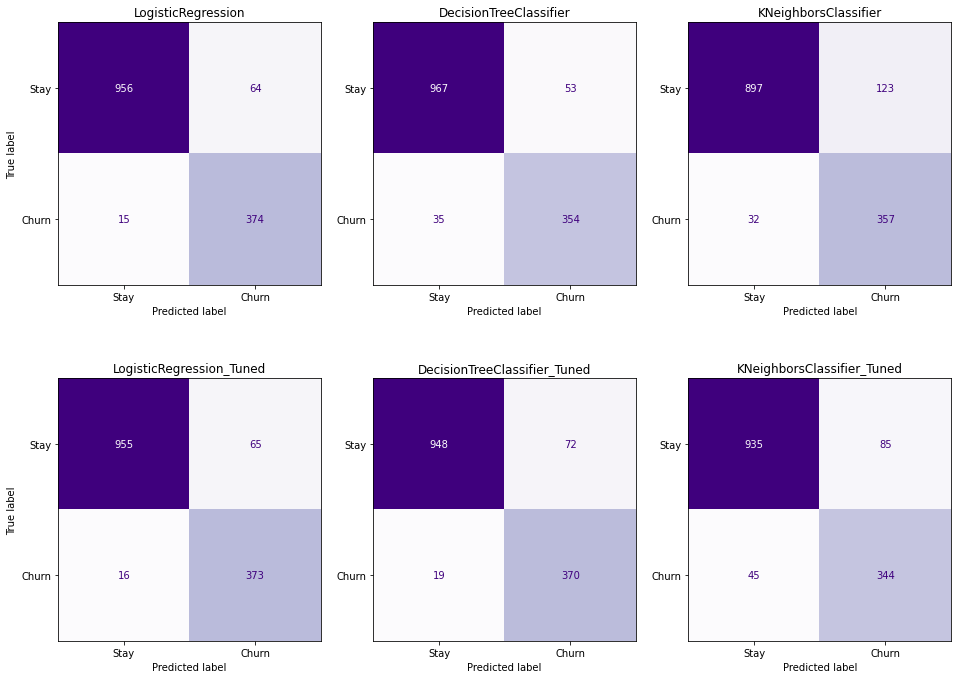

In [40]:
classifiers = [logit, dtree, neigh]  # Before tuning
classifiers2 = [logit2, dtree2, neigh2]  # After tuning

plot_confusion(  # Show confusion matrices
    'img-11', classifiers+classifiers2, X_test, y_test)

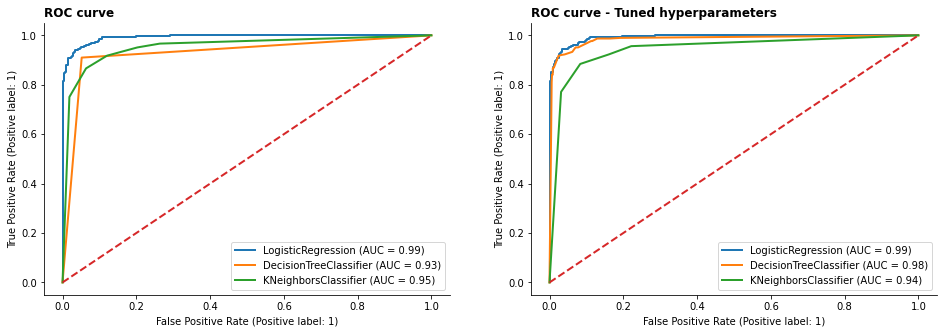

In [41]:
plot_rocs(  # Show ROC curves and AUC scores
    'img-12', classifiers, classifiers2, X_test, y_test)

# Feature importance

The models have performed fairly well in accurately predicting customer churn. However, it is equally important that one also understands which features are most relevant in that prediction. [Feature importance](https://machinelearningmastery.com/calculate-feature-importance-with-python/) is a technique in which input features are assigned a score based on how useful they are at predicting a target variable. It helps us better understand the dataset and can be used to improve the predictive model.

For logistic regression model, feature importance scores can be retrieved from the *coef_* attribute. Positive scores indicate a feature that predicts class 1 (Churn = Yes), whereas the negative scores indicate a feature that predicts class 0 (Churn = No).

In [42]:
logit2_coef = pd.DataFrame({
    'feature': list(X.columns),
    'coefficient': [i for i in logit2.coef_[0]]
}).sort_values('coefficient', ascending=False)
logit2_coef

,feature,coefficient
19,Satisfaction Score_1,12.573879
20,Satisfaction Score_2,10.833884
18,Monthly Charge,1.972157
25,Offer_Offer A,0.751012
34,Contract_Month-to-Month,0.610120
29,Offer_Offer E,0.577743
3,Senior Citizen,0.418222
17,Paperless Billing,0.417338
37,Payment Method_Bank Withdrawal,0.417029
8,Multiple Lines,0.278106


A number of variables have driven customers to be more likely to churn in the past quarter: 
- expressing low satisfaction (esp. score 1 and 2),
- opting for monthly contract,
- paying higher monthly charge,
- purchasing offer A and E,
- being a senior citizen,
- not subscribing to online security service,
- not having dependents, and
- having recently joined (low tenure length).